In [12]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from keras import backend as K
import inception_v4
import numpy as np
import cv2
import os, PIL
from PIL import Image
import tensorflow as tf
from tensorflow.python.platform import gfile
from model import get_keras_objects
import matplotlib.pyplot as plt
from plotly import offline as py, graph_objs as go
import cytoolz as cz



def reduce_tsne(x, **kwargs):
    return TSNE(**kwargs).fit_transform(x)

py.init_notebook_mode()

%matplotlib inline

In [2]:
sess, graph, image, embedding, keras_training = get_keras_objects()

In [3]:
size = 299
folder = "imgs"
features_test = []
path_images = []
for name in os.listdir(folder):
    path = os.path.join(folder,name)
    im = Image.open(path)
    if (im.mode == "RGB"):
        if ( im.size[0] != size or im.size[1] != size): #reshape it
            im = im.resize((size, size,), PIL.Image.ANTIALIAS)
        features_test.append(np.array(im))
        path_images.append(path)

features_test =  np.stack(features_test)
features_test.shape

(441, 299, 299, 3)

In [4]:
predictions = []
for img in features_test:
    pred = sess.run(embedding,{image: [img], keras_training:False })
    predictions.append(np.squeeze(pred))
    
predictions =  np.stack(predictions)
predictions.shape

(441, 1536)

In [29]:
predictions_reduced = reduce_tsne(predictions, n_components=3, perplexity=15.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=2000)
predictions_reduced.shape

(441, 3)

In [35]:
n_clusters = 15
kmeans = KMeans(n_clusters = n_clusters, random_state=0).fit(predictions_reduced)
kmeans.labels_.shape

(441,)

In [33]:
trace1 = go.Scatter3d(
    x=predictions_reduced[:,0],
    y=predictions_reduced[:,1],
    z=predictions_reduced[:,2],
    mode='markers',
    marker=dict(
    size='16',
    color = kmeans.labels_, #set color equal to a variable
    colorscale='Viridis',
    showscale=True
)
)
data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [40]:
trace1 = go.Scatter3d(
    x=predictions_reduced[:,0],
    y=predictions_reduced[:,1],
     z=predictions_reduced[:,2]
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

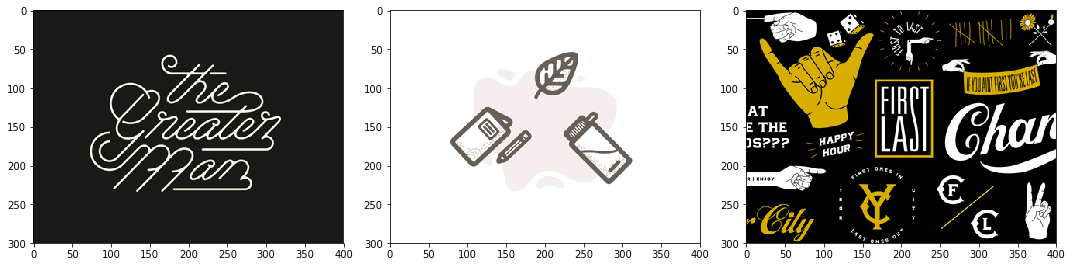

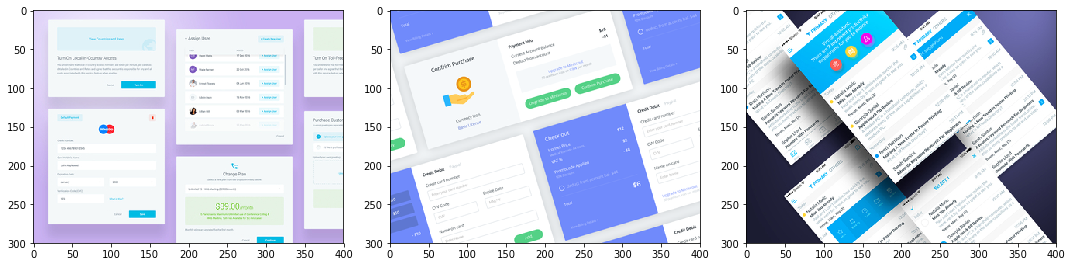

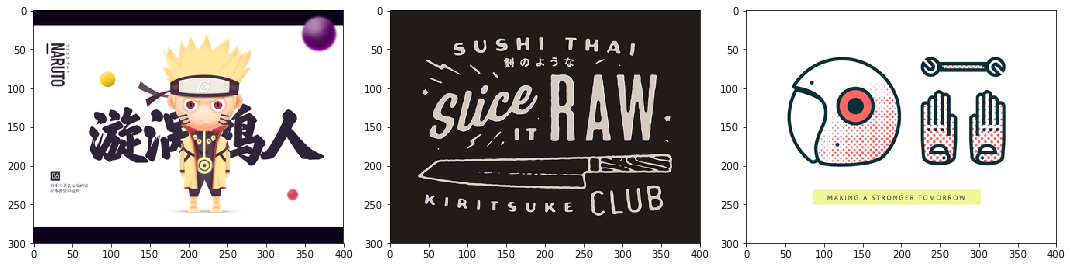

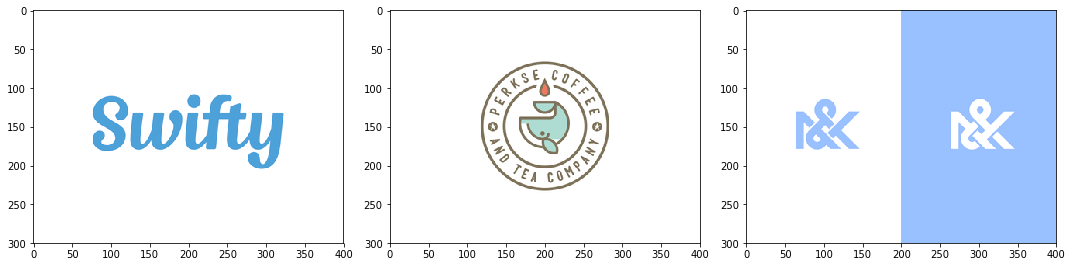

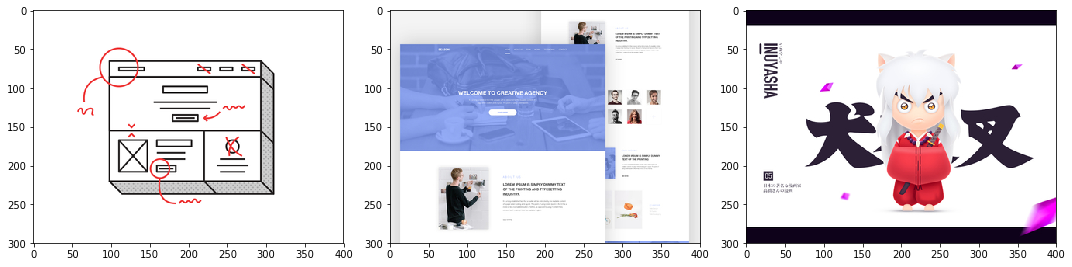

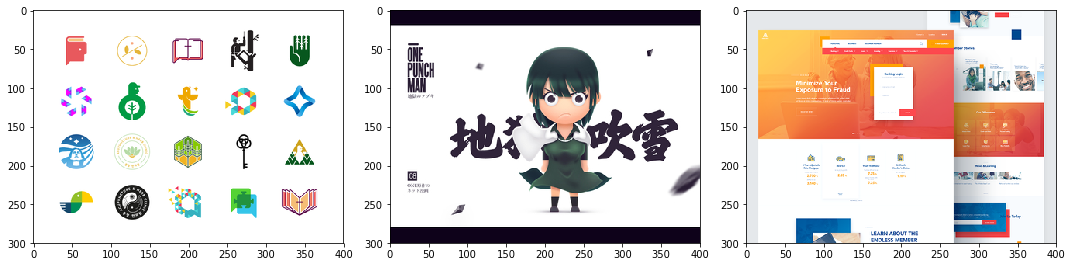

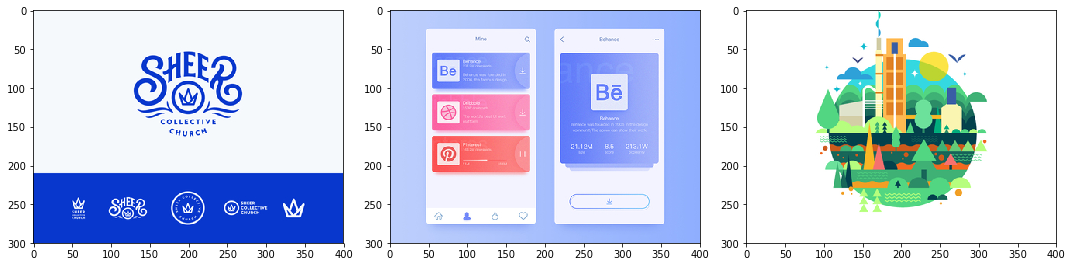

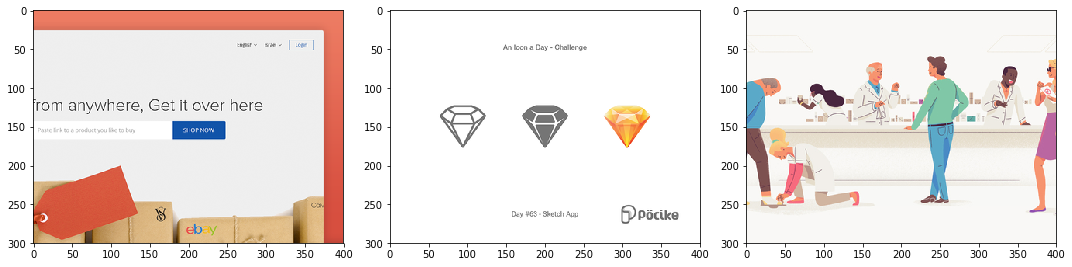

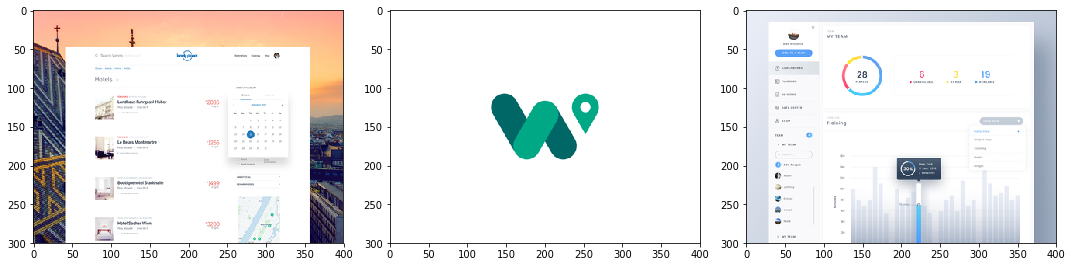

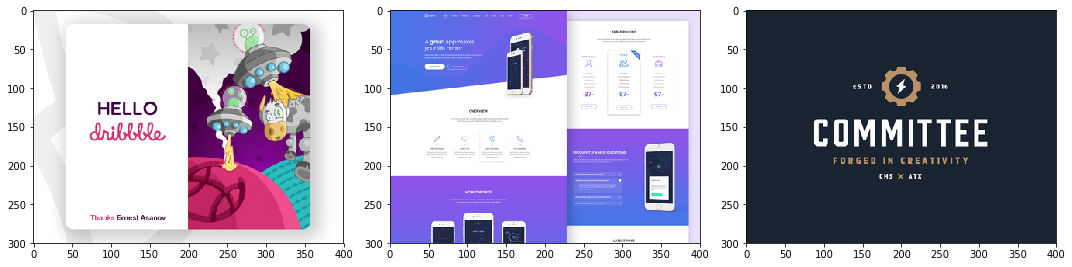

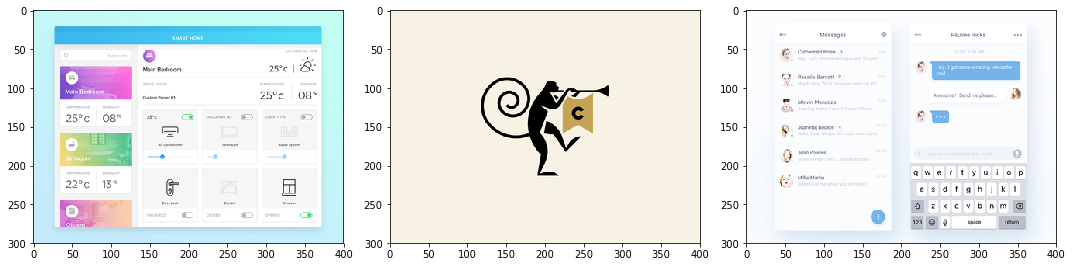

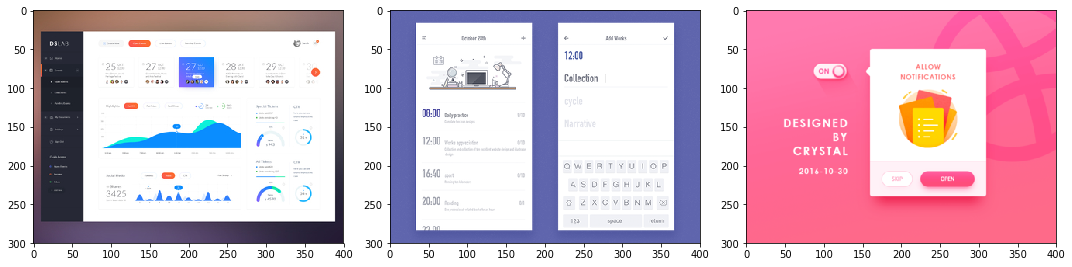

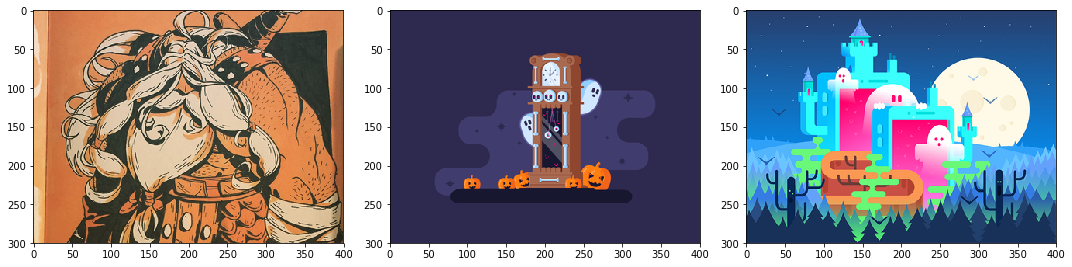

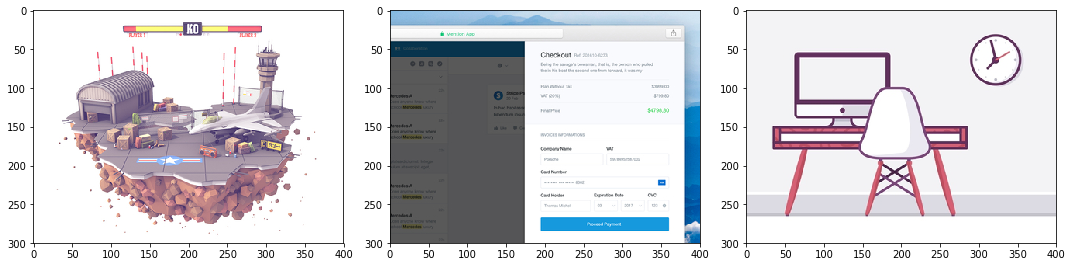

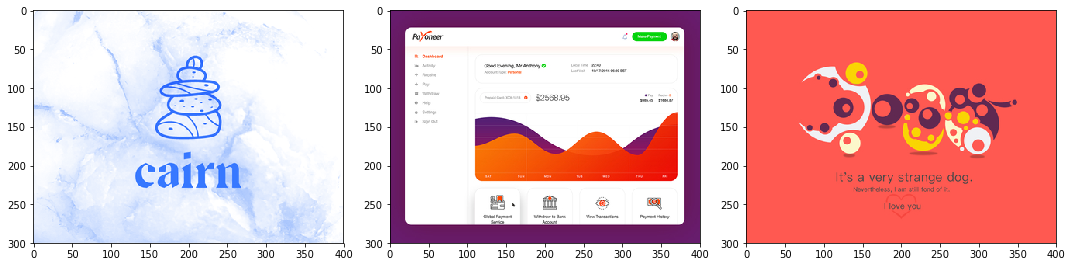

In [36]:
clusters = kmeans.labels_
n_images = 3

for i in range(n_clusters):
    
    f, axs = plt.subplots(1, n_images, figsize=(15,15))
    
    for j, index in enumerate(cz.take(n_images, np.squeeze(np.argwhere(clusters==i)))):
        path = path_images[index]
#         print(index)
        im = Image.open(path)
        axs[j].imshow(np.asarray(im))
    
    f.tight_layout()
    plt.show()


In [59]:
len(path_images)

441